In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

import blackjax

from src.simulation import rdm_experiment_simple

In [2]:
jax.config.update("jax_debug_nans", True)

In [3]:
from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

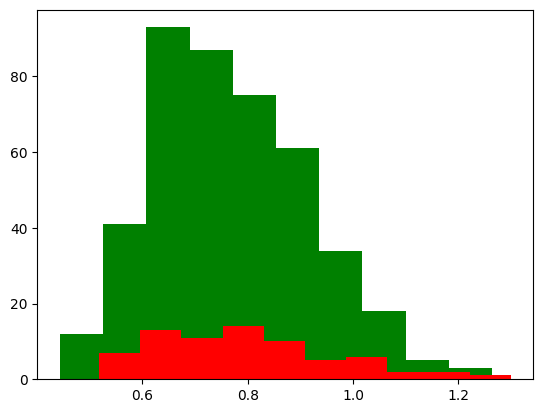

In [4]:
theta = np.array([2, 2, 1, 2, 0.3])

observed = rdm_experiment_simple(theta, 500, np.random.default_rng(2024))

rt_winner = observed[observed[:, 1] == 1, 0]
rt_loser = observed[observed[:, 1] == 0, 0]

plt.hist(rt_winner, color="green")
plt.hist(rt_loser, color="red")

plt.show()

In [5]:
def inv_gauss_pdf(t, mu, lam):
    e = -(lam/(2*t)) * (t**2/mu**2 - 2*t/mu  + 1)

    x = jnp.exp(e + .5*jnp.log(lam) - .5*jnp.log(2*t**3*jnp.pi))
    x = jnp.maximum(0, x)

    return x

def inv_gauss_cdf(t, mu, lam):
    """https://journal.r-project.org/archive/2016-1/giner-smyth.pdf"""
    lam = 1/lam
    mu=mu/lam
    qm = t/mu
    lamm = lam*mu
    r = jnp.sqrt(t*lam)
    a = stats.norm.logsf((qm - 1.0)/r)
    b = 2.0/lamm + stats.norm.logcdf(-(qm + 1.0)/r)
    return a + jnp.log1p(-jnp.exp(b - a))

In [90]:
inv_gauss_cdf(2, 1, 200)

Array(-4.1223416e-23, dtype=float32)

In [10]:
from scipy.stats import invgauss

invgauss.logsf(2, mu=1, scale=200)

-4.1223134033187657e-23

In [11]:
def logp(value, drift_winner, drift_loser, s_winner, s_loser, threshold, ndt, min_p = 1e-14):
        value = value - ndt
        value = jnp.maximum(0.0, value)

        mu_winner = threshold/drift_winner
        mu_loser = threshold/drift_loser
        lam_winner = (threshold/s_winner)**2
        lam_loser = (threshold/s_loser)**2

        f = jnp.log(jnp.piecewise(value, [value <= 0.0, value > 0.0], [min_p, lambda x: inv_gauss_pdf(x, mu_winner, lam_winner)]))
        S = jnp.piecewise(value, [value <= 0.0, value > 0.0], [0.0, lambda x: inv_gauss_cdf(x, mu_loser, lam_loser)])

        # S = jnp.where(value <= 0.0, 0.0, F)

        logp = f + S

        logp = jnp.maximum(jnp.where(jnp.isinf(logp) | jnp.isnan(logp), jnp.log(min_p), logp), jnp.log(min_p))

        return logp

In [76]:
jnp.sum(logp(rt_winner, 4.0, 2.0, 1.0, 1.0, 2.0, 0.3))

Array(206.4064, dtype=float32)

In [84]:
jnp.sum(logp(rt_loser, 2.0, 4.0, 1.0, 1.0, 2.0, 0.3))

Array(-46.129692, dtype=float32)

In [13]:
grad_fn = jax.grad(logp)
grad_fn(0.01, 2.0, 2.0, 1.0, 1.0, 2.0, 0.3)

Array(0., dtype=float32, weak_type=True)

In [77]:
def sumlogp(drift_intercept, drift_slope, s_winner, threshold, ndt, rt_winner=rt_winner, rt_loser=rt_loser):
    drift_intercept = jnp.exp(drift_intercept)
    drift_slope = jnp.exp(drift_slope)
    s_winner = jnp.exp(s_winner)
    threshold = jnp.exp(threshold)
    ndt = jnp.exp(ndt)

    drift_loser = drift_intercept
    drift_winner = drift_intercept + drift_slope 

    # print(drift_winner, drift_loser, threshold)

    ll_winner = logp(rt_winner, drift_winner=drift_winner, drift_loser=drift_loser, s_winner=s_winner, s_loser=1.0, threshold=threshold, ndt=ndt)
    ll_loser = logp(rt_loser, drift_winner=drift_loser, drift_loser=drift_winner, s_winner=1.0, s_loser=s_winner, threshold=threshold, ndt=ndt)

    return jnp.sum(ll_winner) + jnp.sum(ll_loser)

logdensity = lambda x: sumlogp(**x)

In [87]:
sumlogp(jnp.log(0.2), jnp.log(6), jnp.log(1.0), jnp.log(2.0), jnp.log(0.3))

Array(-323.0796, dtype=float32)

In [54]:
grad_fn = jax.grad(sumlogp)
grad_fn(jnp.log(4.0), jnp.log(1.0), jnp.log(1.0), jnp.log(4.0), jnp.log(0.3))

Array(3394.9634, dtype=float32)

In [17]:
initial_position = {
    "drift_intercept": np.log(2.0),
    "drift_slope": np.log(2.0),
    "s_winner": np.log(1.0),
    "threshold": np.log(2.0),
    "ndt": np.log(0.3)
}

logdensity(initial_position)

Array(160.2767, dtype=float32)

In [18]:
def transform_dict(d):
    return {k: np.log(v) for k, v in d.items()}

In [19]:
logdensity(initial_position)

Array(160.2767, dtype=float32)

In [20]:
warmup = blackjax.pathfinder_adaptation(blackjax.hmc, logdensity, num_integration_steps=1000)

In [ ]:
(init_state, parameters), _ = warmup.run(rng_key, initial_position)

In [ ]:
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(warmup_key, initial_position, num_steps=1000)

In [97]:
init_state, parameters

(HMCState(position={'drift_intercept': Array(nan, dtype=float32), 'drift_slope': Array(nan, dtype=float32), 'ndt': Array(nan, dtype=float32), 's_winner': Array(nan, dtype=float32), 'threshold': Array(nan, dtype=float32)}, logdensity=Array(nan, dtype=float32), logdensity_grad={'drift_intercept': Array(nan, dtype=float32), 'drift_slope': Array(nan, dtype=float32), 'ndt': Array(nan, dtype=float32), 's_winner': Array(nan, dtype=float32), 'threshold': Array(nan, dtype=float32)}),
 {'step_size': Array(0., dtype=float32, weak_type=True),
  'inverse_mass_matrix': Array([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]], dtype=float32),
  'num_integration_steps': 1000})

In [21]:
inv_mass_matrix = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
num_integration_steps = 100
step_size = 1e-3

hmc = blackjax.hmc(logdensity, step_size, inv_mass_matrix, num_integration_steps)

In [22]:
initial_state = hmc.init(initial_position)
initial_state

HMCState(position={'drift_intercept': 0.6931471805599453, 'drift_slope': 0.6931471805599453, 's_winner': 0.0, 'threshold': 0.6931471805599453, 'ndt': -1.2039728043259361}, logdensity=Array(160.2767, dtype=float32), logdensity_grad={'drift_intercept': Array(240.0369, dtype=float32), 'drift_slope': Array(102.53848, dtype=float32), 'ndt': Array(-244.06184, dtype=float32), 's_winner': Array(-29.931662, dtype=float32), 'threshold': Array(-411.13553, dtype=float32)})

In [23]:
hmc_kernel = jax.jit(hmc.step)

In [24]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [25]:
%%time
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, hmc_kernel, initial_state, 10_000)

mcmc_samples = states.position
# mcmc_samples["scale"] = jnp.exp(mcmc_samples["log_scale"]).block_until_ready()

CPU times: user 45.3 s, sys: 4.66 s, total: 50 s
Wall time: 34.4 s


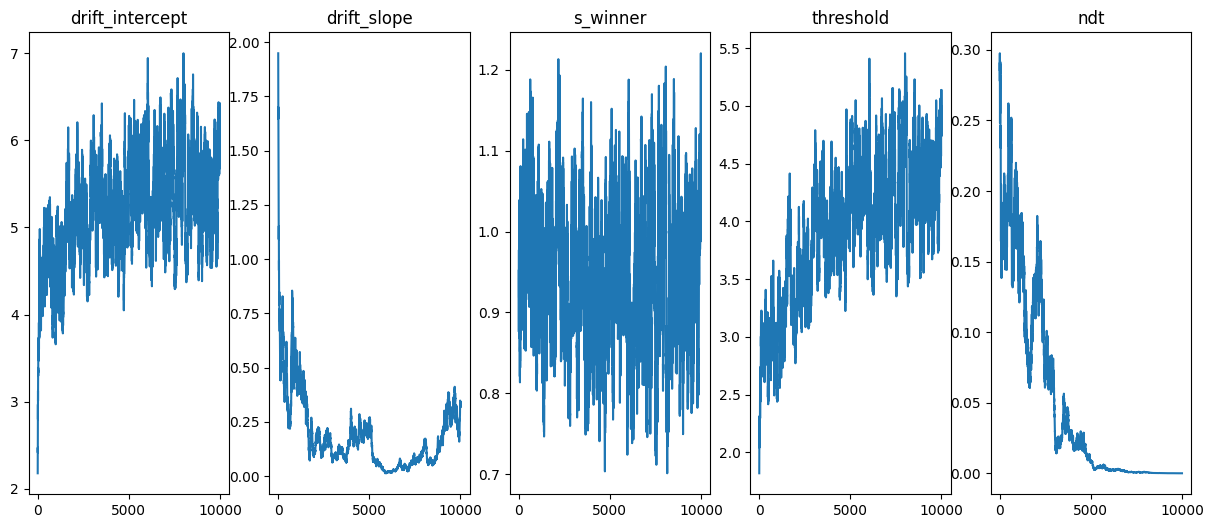

In [26]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 6))

for k, ax in zip(initial_position.keys(), axes):
    ax.set_title(k)
    ax.plot(np.exp(mcmc_samples[k]))

In [28]:
nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [29]:
initial_state = nuts.init(initial_position)
initial_state

HMCState(position={'drift_intercept': 0.6931471805599453, 'drift_slope': 0.6931471805599453, 's_winner': 0.0, 'threshold': 0.6931471805599453, 'ndt': -1.2039728043259361}, logdensity=Array(160.2767, dtype=float32), logdensity_grad={'drift_intercept': Array(240.0369, dtype=float32), 'drift_slope': Array(102.53848, dtype=float32), 'ndt': Array(-244.06184, dtype=float32), 's_winner': Array(-29.931662, dtype=float32), 'threshold': Array(-411.13553, dtype=float32)})

In [30]:
rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, nuts.step, initial_state, 4_000)
mcmc_samples = states.position

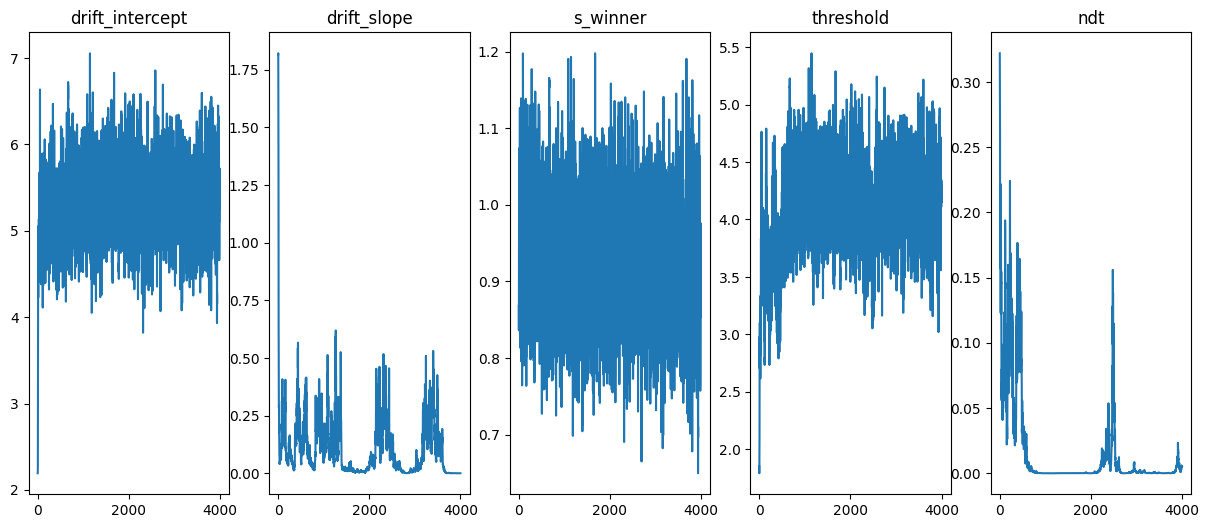

In [31]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 6))

for k, ax in zip(initial_position.keys(), axes):
    ax.set_title(k)
    ax.plot(np.exp(mcmc_samples[k]))